In [55]:
import sys
import os
import cv2
import numpy as np
import random
from matplotlib import pyplot as plt
from IPython.display import clear_output
%matplotlib inline

### Intensity based Object Tracking

In [56]:
# Setup for object tracking
if not os.path.isdir(os.path.join(os.getcwd(), 'frames')):
    os.mkdir("frames")
else:
    print('frames already exists')

if not os.path.isdir(os.path.join(os.getcwd(), 'composite')):
    os.mkdir("composite")
else:
    print('composite already exists')

framenumber = 0
framectr = 0
omovie = cv2.VideoCapture('ping_pang.mov')
frame_height = omovie.get(cv2.CAP_PROP_FRAME_HEIGHT)
frame_width  = omovie.get(cv2.CAP_PROP_FRAME_WIDTH)

# Extract the frames from original video
while(1):
    ret, frame = omovie.read()
    if not ret:
        break
    print('Extracting: %d' % framenumber)
    clear_output(wait=True)
    cv2.imwrite('frames/%d.tif' % framenumber, frame)
    framenumber += 1
omovie.release()

Extracting: 119


In [71]:

def findObj(frame):
    if len(frame.shape) == 3:
        gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    else:
        gray_frame = frame

    _, binary_frame = cv2.threshold(gray_frame, 250, 255, cv2.THRESH_BINARY)

    foreground_indices = np.argwhere(binary_frame > 0)
    if foreground_indices.size <= 10:
        object_x, object_y = -1,-1
    else:
        object_y, object_x = np.mean(foreground_indices[:, 0]), np.mean(foreground_indices[:, 1])
        object_x, object_y = int(round(object_x)), int(round(object_y))

    return [object_x, object_y]


# Draw a circle on the image.
def drawbox(frame, centerx, centery, radius, color):
    for y in range(centery - radius, centery + radius):
        for x in range(centerx - radius, centerx + radius):
            cy = 0 if y < 0 else frame.shape[0] - 1 if y > frame.shape[0] - 1 else y
            cx = 0 if x < 0 else frame.shape[1] - 1 if x > frame.shape[1] - 1 else x
            for i in range(3):
                frame[cy][cx][i] = color[i]
    return frame

In [74]:
framectr = framenumber - 1
process_frame = 0

foreground_tvalue = 250 # Foreground Threshold-Value (tvalue) for Segmentation
coordListX = list()
coordListY = list()

while process_frame <= framectr:
    # Only keep a small range of frames to save the processing time, i.e., frames within (53, 94).
    if process_frame > 94:
        print("Stop processing frames to save time")
        break
    if process_frame < 53:
        process_frame += 1
        continue

    # Read RGB frame
    rgb_frame = cv2.imread('frames/%d.tif' % process_frame)
    print('Processing frame: %d, overall progress: %.2f %%' % (process_frame, process_frame/framectr*100))
    clear_output(wait=True)

    # Object Segmentation
    # 1. convert rgb_frame to gray scale,
    # 2. then perform foreground segmentation (based on its grayscale values).
    gframe = rgb_frame.copy()
    for y in range(gframe.shape[1]):
        for x in range(gframe.shape[0]):
            g = 0.212671 * gframe[x][y][2] + 0.715160 * gframe[x][y][1] + 0.072169 * gframe[x][y][0]
            for i in range(3):
                gframe[x][y][i] = 255 if g > foreground_tvalue else 0
    coord = findObj(gframe)
    if coord[0] != -1 and coord[1] != -1:
        print(coord[0], coord[1])
        coordListX.append(int(coord[0]))
        coordListY.append(int(coord[1]))

        for i in range(1, len(coordListX)):
            cv2.line(rgb_frame, (coordListX[i-1], coordListY[i-1]), (coordListX[i], coordListY[i]), (255, 0, 0), 2)

            cv2.putText(rgb_frame, 'Object Found', (50, 50), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)

        rgb_frame = drawbox(rgb_frame, int(coord[0]), int(coord[1]), 5, (0, 0, 255))
        gframe    = drawbox(gframe   , int(coord[0]), int(coord[1]), 5, (0, 0, 255))
    else:
        cv2.putText(rgb_frame, 'Object Not Found', (50, 50), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)
    combined_img = np.hstack((rgb_frame, gframe))
    ####################################### END ################################################

    cv2.imwrite('composite/composite%d.tif' % process_frame, combined_img)
    if cv2.waitKey(30) & 0xff == ord('q'):
        break
    process_frame += 1

Foreground Indices Size: 2146
Foreground Indices Shape: (1073, 2)
2146
18 659
Stop processing frames to save time


In [75]:
count = 53
out = cv2.VideoWriter('./happy_ping_pang.mov', cv2.VideoWriter_fourcc('M', 'J', 'P', 'G'), 10, (int(frame_width*2), int(frame_height)))
# If you encounter format issue with the above line, you could try the following line to extract the video instead.
# out = cv2.VideoWriter('./happy_ping_pang.mp4', cv2.VideoWriter_fourcc(*'mp4v'), 10, (int(frame_width*2), int(frame_height)))
while(1):
    img = cv2.imread('composite/composite%d.tif' % count)
    if img is None:
        print('No more frames to be loaded')
        break
    clear_output(wait=True)
    out.write(img)
    count += 1
    print('Saving video: %d%%' % int(100*count/framenumber))

out.release()
cv2.destroyAllWindows()

Saving video: 79%
No more frames to be loaded


[ WARN:0@5288.820] global loadsave.cpp:248 findDecoder imread_('composite/composite95.tif'): can't open/read file: check file path/integrity


### Intensity based Object Tracking

In [76]:
def generate_results(wk, name, SID, output_video):
    cap = cv2.VideoCapture(output_video)
    random_frames = []
    if not cap.isOpened():
        print('%s not opened' % output_video.split('/')[-1])
        sys.exit(1)

    frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    x = cap.get(cv2.CAP_PROP_FRAME_HEIGHT)
    y = cap.get(cv2.CAP_PROP_FRAME_WIDTH)
    while x > 10:
        x /= (x / 10)
        y /= (y / 10)

    random_frames.append(random.randint(53, 63))
    random_frames.append(random.randint(66, 76))
    random_frames.append(random.randint(80, 94))

    fig, axs = plt.subplots(3, 1, figsize=(x,y))

    count = 53
    output_count = 0
    while(1):
        ret, frame = cap.read()
        if not ret:
            break
        if count in random_frames:
            frame_m = frame.copy()
            frame_R = frame[:,:,2]
            frame_B = frame[:,:,0]
            frame_m[:,:,2] = frame_B
            frame_m[:,:,0] = frame_R
            frame = np.uint8(frame_m)

            axs[output_count].imshow(frame_m)
            axs[output_count].text(0.5, -0.1, 'Composite frame: ' + str(count), size=12, ha="center", transform=axs[output_count].transAxes)
            axs[output_count].axis('off')
            output_count+=1

            if output_count >= 3:
                break
        count+=1

    cap.release()
    cv2.destroyAllWindows()
    fig.suptitle("Week %i Lab Exercise\n %s SID:%i"%(wk, name, SID),x=0.5,y=1.05)
    plt.tight_layout()
    plt.show()

In [61]:
if not os.path.exists("./happy_ping_pang.mov"):
    print("File not found!")
else:
    print("file found")

file found


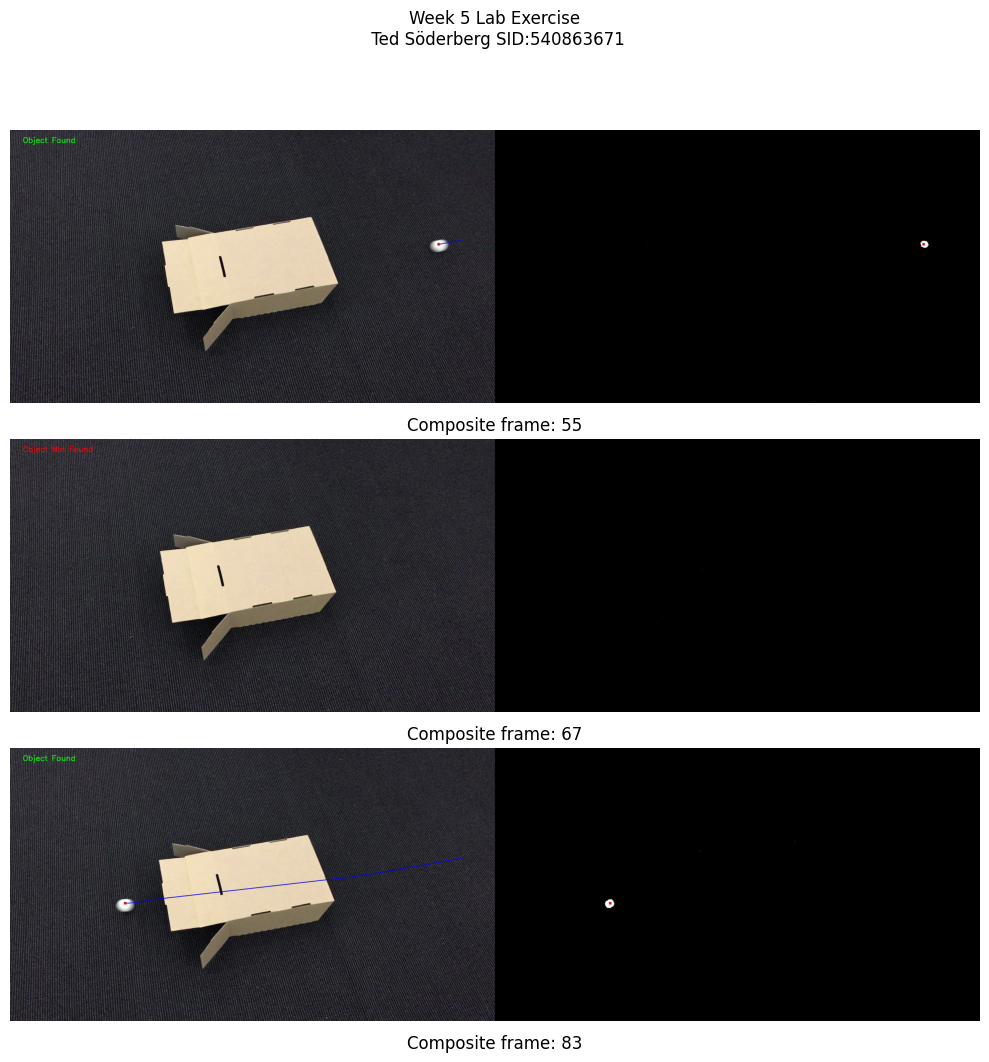

In [77]:
# Change the 'path_to_output' to the path where your composited video is located
path_to_output = './happy_ping_pang.mov'
generate_results(5, 'Ted Söderberg', 540863671, path_to_output)